<a href="https://colab.research.google.com/github/fgprevito/building-intuition/blob/main/building_intuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

In [2]:
def spreadsheet_data(NUM_SECTORS, NUM_COMPANIES_PER_SECTOR, START_YEAR, NUM_YEARS):

  snames = ['Sector'+str(x) for x in range(NUM_SECTORS)]
  cnames = [['FakeCo'+str(x)+'-'+sector_name for x in range(NUM_COMPANIES_PER_SECTOR)] for sector_name in snames]
  cnames = [item for sublist in cnames for item in sublist]

  rows = []
  for cc in cnames:
    implied_sector = cc.split('-')[1]
    for yy in range(NUM_YEARS):
      rows.append([cc, implied_sector, START_YEAR + yy])

  df = pandas.DataFrame(data=rows, columns=['Company Name', 'Sector', 'Year'])
  return df

In [3]:
def company_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1):

  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) } # Creates a flipped data dictionary consisting of each unique company in the dataframe
  company_level_values = numpy.random.rand(len(company_levels)) # creating the true parameters I want to later calculate

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']]) # creates an array of each respective company's parameters

  noisy_company_returns = plain_company_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0]) # adjusts the noise level on those parameters
  noisy_company_returns[1] *= SINGLE_VAR_NOISE
  df['Return'] = noisy_company_returns # returns a pandas dataframe column called 'Return' consisting of returns whose values are affected only by the company variable

  true_weights = company_level_values

  return df, true_weights

In [4]:
def company_sector_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1):

  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) }
  company_level_values = numpy.random.rand(len(company_levels))

  sector_levels = { x : ii for (ii,x) in enumerate(df['Sector'].unique()) }
  sector_level_values = numpy.random.rand(len(sector_levels))

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']])
  plain_sector_returns = numpy.array([sector_level_values[sector_levels[x]] for x in df['Sector']])

  noisy_returns = plain_company_returns + plain_sector_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0])
  noisy_returns[1] *= SINGLE_VAR_NOISE
  df['Return'] = noisy_returns

  true_weights = numpy.concatenate((company_level_values, sector_level_values))

  return df, true_weights

In [5]:
def company_sector_year_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1):

  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) }
  company_level_values = numpy.random.rand(len(company_levels))

  sector_levels = { x : ii for (ii,x) in enumerate(df['Sector'].unique()) }
  sector_level_values = numpy.random.rand(len(sector_levels))

  year_levels = { x : ii for (ii,x) in enumerate(df['Year'].unique()) }
  year_level_values = numpy.random.rand(len(year_levels))

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']])
  plain_sector_returns = numpy.array([sector_level_values[sector_levels[x]] for x in df['Sector']])
  plain_year_returns = numpy.array([year_level_values[year_levels[x]] for x in df['Year']])

  noisy_returns = plain_company_returns + plain_sector_returns + plain_year_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0])
  noisy_returns[1] *= SINGLE_VAR_NOISE
  df['Return'] = noisy_returns

  true_weights = numpy.concatenate((company_level_values, sector_level_values, year_level_values))

  return df, true_weights

In [6]:
def design_matrix_company(the_spreadsheet):

  unique_companies = { x : ii for (ii,x) in enumerate(the_spreadsheet['Company Name'].unique()) }

  num_unique_companies = len(unique_companies)

  design_matrix = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies))
  for ii, cn in enumerate(the_spreadsheet['Company Name']):
    design_matrix[ii, unique_companies[cn]] = 1

  return design_matrix

In [7]:
def design_matrix_company_sector(the_spreadsheet):

  unique_companies = { x : ii for ii,x in enumerate(the_spreadsheet['Company Name'].unique()) }
  unique_sectors = { x : ii for ii,x in enumerate(the_spreadsheet['Sector'].unique()) }

  num_unique_companies = len(unique_companies)
  num_unique_sectors = len(unique_sectors)

  design_matrix = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies + num_unique_sectors))
  for ii, (cn, sn) in enumerate(zip(the_spreadsheet['Company Name'], the_spreadsheet['Sector'])):
    design_matrix[ii, unique_companies[cn]] = 1
    design_matrix[ii, num_unique_companies + unique_sectors[sn]] = 1

  return design_matrix

In [8]:
def design_matrix_company_sector_year(the_spreadsheet):

  unique_companies = { x : ii for ii,x in enumerate(the_spreadsheet['Company Name'].unique()) }
  unique_sectors = { x : ii for ii,x in enumerate(the_spreadsheet['Sector'].unique()) }
  unique_years = { x : ii for ii,x in enumerate(the_spreadsheet['Year'].unique()) }

  num_unique_companies = len(unique_companies)
  num_unique_sectors = len(unique_sectors)
  num_unique_years = len(unique_years)

  design_matrix = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies + num_unique_sectors + num_unique_years))
  for ii, (cn, sn, yr) in enumerate(zip(the_spreadsheet['Company Name'], the_spreadsheet['Sector'], the_spreadsheet['Year'])):
    design_matrix[ii, unique_companies[cn]] = 1
    design_matrix[ii, num_unique_companies + unique_sectors[sn]] = 1
    design_matrix[ii, num_unique_companies + num_unique_sectors + unique_years[yr]] = 1

  return design_matrix

A design matrix is nothing but a landscape for me to record which factors affect which outcomes

In [9]:
def covariance_matrix(design_matrix):
  print('Covariance Matrix: ')
  print(numpy.dot(design_matrix.T, design_matrix))

  return

def precision_matrix(design_matrix):
  print('Precision Matrix: ')
  print(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)))

  return

def hat_matrix(design_matrix):
  print('Hat Matrix: ')
  print(numpy.dot(numpy.dot(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)), design_matrix.T), outcomes))

  return

In [10]:
def variable_analysis(design_matrix):

  vmax = numpy.max(numpy.abs(design_matrix[0]))

  covariance = numpy.dot(design_matrix.T, design_matrix)
  precision = numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix))
  hat = numpy.dot(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)), design_matrix.T)

  figure, axes = plt.subplots(1, 3, figsize=(20, 5))

  # can add annot=True and fmt=' ' to add annotations within boxes in heatmap
  seaborn.heatmap(covariance, cmap="coolwarm", center=0, vmin=-vmax, vmax=vmax, ax=axes[0])
  axes[0].set_title('Covariance Matrix')

  seaborn.heatmap(precision, cmap="coolwarm", center=0, vmin=-vmax, vmax=vmax, ax=axes[1])
  axes[1].set_title('Precision Matrix')

  seaborn.heatmap(hat, cmap="coolwarm", center=0, vmin=-vmax, vmax=vmax, ax=axes[2])
  axes[2].set_title('Hat Matrix')

  plt.show()

  return

In [11]:
def model_weights_accuracy(true_weights, predicted_weights):

  plt.plot([0,1], [0,1], 'r-')
  plt.plot(true_weights, predicted_weights, 'k.')

  plt.xlabel('True Weights')
  plt.ylabel('Predicted Weights')

  return

def model_outcomes_accuracy(true_outcomes, predicted_outcomes):

  plt.plot([0,1], [0,1], 'r-')
  plt.plot(true_outcomes, predicted_outcomes, 'k.')

  plt.xlabel('True Outcomes')
  plt.ylabel('Predicted Outcomes')

  return

In [12]:
def evaluation_metrics(actual_weights, predicted_weights, actual_outcomes, predicted_outcomes):

  MSE = print('Mean Squared Error:', numpy.mean((predicted_outcomes - actual_outcomes)**2))
  ME = print('Mean Weight Error:', numpy.mean(actual_weights - predicted_weights))
  Variance = print('Model Variance:', numpy.var(actual_weights - predicted_weights))
  Std_Dev = print('Standard Deviation:', numpy.std(actual_weights - predicted_weights))

  return



---

Generating a set of simulated input variabels

---



In [13]:
df = spreadsheet_data(NUM_SECTORS=2, NUM_COMPANIES_PER_SECTOR=2, START_YEAR=2018, NUM_YEARS=4)
data, weights = company_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1)
data

,Company Name,Sector,Year,Return
0,FakeCo0-Sector0,Sector0,2018,0.787729
1,FakeCo0-Sector0,Sector0,2019,0.787729
2,FakeCo0-Sector0,Sector0,2020,0.787729
3,FakeCo0-Sector0,Sector0,2021,0.787729
4,FakeCo1-Sector0,Sector0,2018,0.296744
5,FakeCo1-Sector0,Sector0,2019,0.296744
6,FakeCo1-Sector0,Sector0,2020,0.296744
7,FakeCo1-Sector0,Sector0,2021,0.296744
8,FakeCo0-Sector1,Sector1,2018,0.767369
9,FakeCo0-Sector1,Sector1,2019,0.767369




---

Design matrix formats the data in a way that I can explain the outputs in term sof the inputs

---

design : every row corresponds to an observation
ex. fakeco0sector0 in 2018 and there's 4 factors (4 columns)
in this case this design matrix is a 0,1 matrix

doesnt have to be

just a factor saying fakeco0

In [14]:
design = design_matrix_company(data)
design

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])



---

Matrix rank helps me determine the # of independent features

---

we have a deisgn amtrix with 4 columns and 16 rows
matrix shape: 16,4
matrix rank: 4
MAtrix Rank:...

In [15]:
matrix_rank = numpy.linalg.matrix_rank(design)
print('Matrix Shape:', design.shape, '\n\n' + 'Matrix Rank:', matrix_rank)

Matrix Shape: (16, 4) 

Matrix Rank: 4




---

Function is working as intended, company name is the only thing affecting returns

This will be the relationship I'll attempt to capture with a linear regression

---



In [16]:
# covariance
numpy.dot(design.T, design)

array([[4., 0., 0., 0.],
       [0., 4., 0., 0.],
       [0., 0., 4., 0.],
       [0., 0., 0., 4.]])

In [17]:
# precision
numpy.linalg.pinv(numpy.dot(design.T, design))

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [ ]:
# look into this

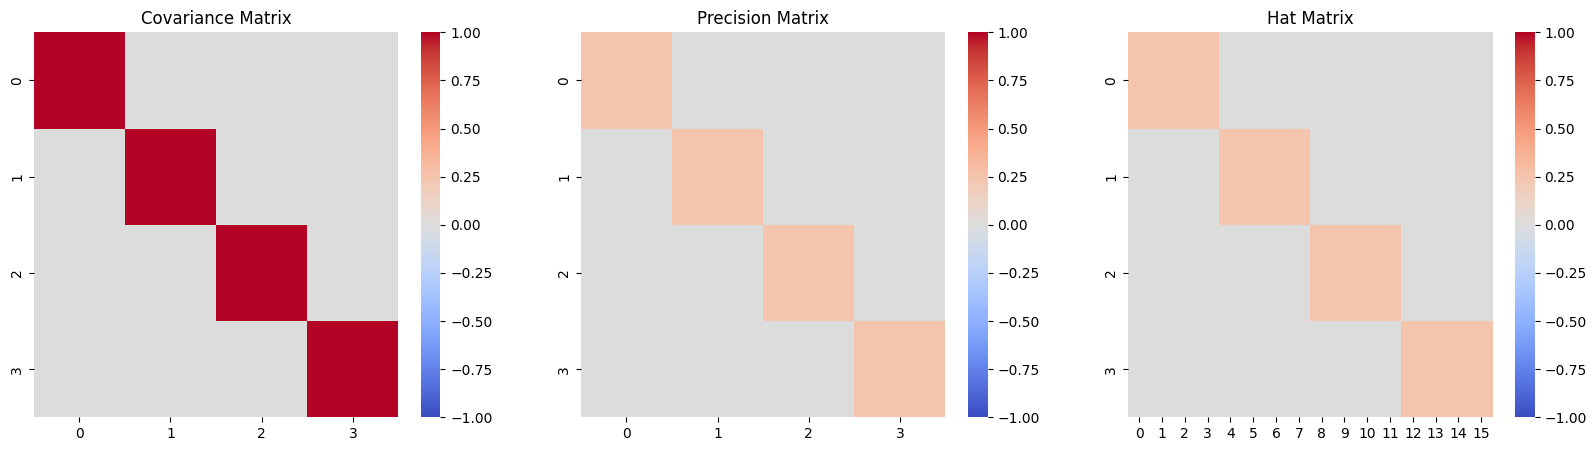

In [18]:
variable_analysis(design)

Enter SKLearn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
true_outcomes = data['Return']

linear = LinearRegression(fit_intercept=False) # input, output, intercept
linear.fit(design, true_outcomes)
linear_outcomes = linear.predict(design)
linear_weights = linear.coef_

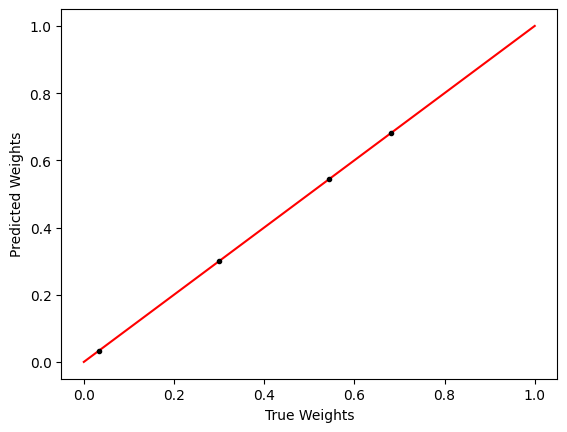

In [ ]:
model_weights_accuracy(weights, linear_weights)

In [ ]:
pred_outcomes = numpy.dot(design, linear_weights)
pred_outcomes

array([0.54315655, 0.54315655, 0.54315655, 0.54315655, 0.30048519,
       0.30048519, 0.30048519, 0.30048519, 0.68026917, 0.68026917,
       0.68026917, 0.68026917, 0.03393139, 0.03393139, 0.03393139,
       0.03393139])

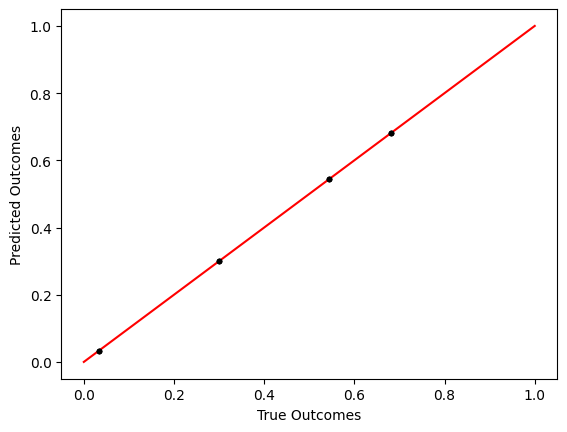

In [ ]:
model_outcomes_accuracy(true_outcomes, linear_outcomes)

In [ ]:
evaluation_metrics(weights, linear_weights, true_outcomes, linear_outcomes)

Mean Squared Error: 0.0
Mean Weight Error: 0.0
Model Variance: 0.0
Standard Deviation: 0.0




---


Sanity check. Everything working as conceptually intended


---


Let's consider a second variable


---




In [ ]:
data, weights = company_sector_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1)
data

,Company Name,Sector,Year,Return
0,FakeCo0-Sector0,Sector0,2018,0.627600
1,FakeCo0-Sector0,Sector0,2019,0.627600
2,FakeCo0-Sector0,Sector0,2020,0.627600
3,FakeCo0-Sector0,Sector0,2021,0.627600
4,FakeCo1-Sector0,Sector0,2018,1.107101
5,FakeCo1-Sector0,Sector0,2019,1.107101
6,FakeCo1-Sector0,Sector0,2020,1.107101
7,FakeCo1-Sector0,Sector0,2021,1.107101
8,FakeCo0-Sector1,Sector1,2018,0.961891
9,FakeCo0-Sector1,Sector1,2019,0.961891


In [ ]:
design = design_matrix_company_sector(data)
design

array([[1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.]])

In [ ]:
matrix_rank = numpy.linalg.matrix_rank(design)
print('Matrix Shape:', design.shape, '\n\n' + 'Matrix Rank:', matrix_rank)

Matrix Shape: (16, 6) 

Matrix Rank: 4




---

Rank deficiency...

---



Learn covariance/matrix rank

In [ ]:
# covariance
numpy.dot(design.T, design)

array([[4., 0., 0., 0., 4., 0.],
       [0., 4., 0., 0., 4., 0.],
       [0., 0., 4., 0., 0., 4.],
       [0., 0., 0., 4., 0., 4.],
       [4., 4., 0., 0., 8., 0.],
       [0., 0., 4., 4., 0., 8.]])

In [ ]:
# precision
numpy.linalg.pinv(numpy.dot(design.T, design))

array([[ 0.13888889, -0.11111111,  0.        ,  0.        ,  0.02777778,
         0.        ],
       [-0.11111111,  0.13888889,  0.        ,  0.        ,  0.02777778,
         0.        ],
       [ 0.        ,  0.        ,  0.13888889, -0.11111111,  0.        ,
         0.02777778],
       [ 0.        ,  0.        , -0.11111111,  0.13888889,  0.        ,
         0.02777778],
       [ 0.02777778,  0.02777778,  0.        ,  0.        ,  0.05555556,
         0.        ],
       [ 0.        ,  0.        ,  0.02777778,  0.02777778,  0.        ,
         0.05555556]])

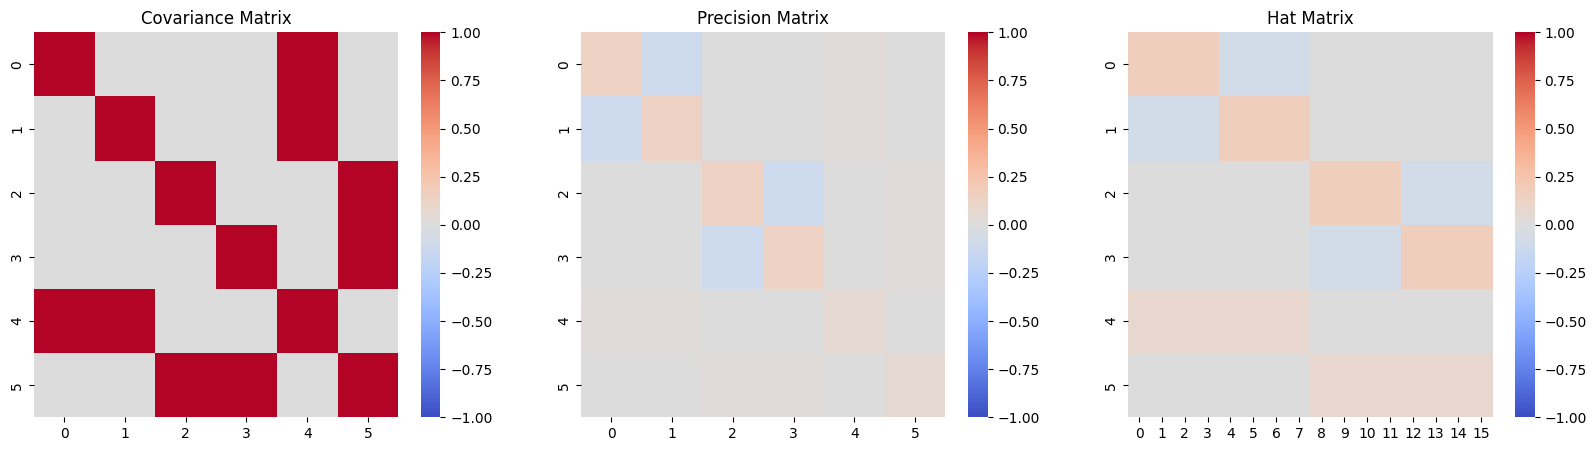

In [ ]:
variable_analysis(design)

In [ ]:
true_outcomes = data['Return']

linear = LinearRegression(fit_intercept=False) # input, output, intercept
linear.fit(design, true_outcomes)
linear_outcomes = linear.predict(design)
linear_weights = linear.coef_

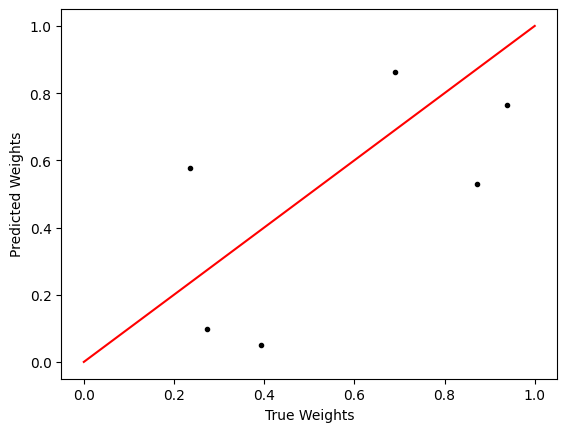

In [ ]:
model_weights_accuracy(weights, linear_weights)

In [ ]:
pred_outcomes = numpy.dot(design, linear_weights)
pred_outcomes

array([0.62759975, 0.62759975, 0.62759975, 0.62759975, 1.1071009 ,
       1.1071009 , 1.1071009 , 1.1071009 , 0.96189144, 0.96189144,
       0.96189144, 0.96189144, 1.62885043, 1.62885043, 1.62885043,
       1.62885043])

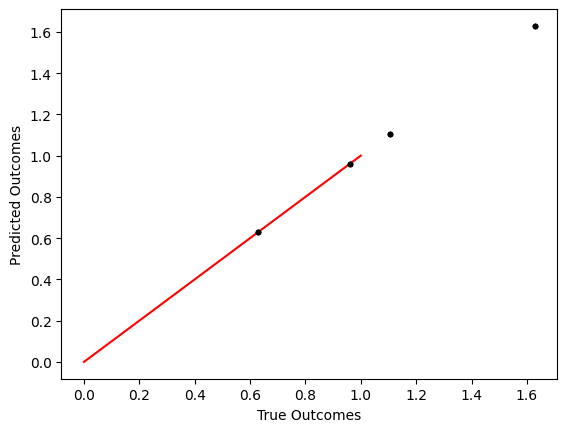

In [ ]:
model_outcomes_accuracy(true_outcomes, linear_outcomes)

In [ ]:
evaluation_metrics(weights, linear_weights, true_outcomes, linear_outcomes)

Mean Squared Error: 1.1401505270772436e-31
Mean Weight Error: 0.0862650026615644
Model Variance: 0.06669550874846138
Standard Deviation: 0.25825473615881933




---

Back to 1 variable, this time with noise

---



In [ ]:
data, weights = company_affects(df, NOISE_LEVEL=2, SINGLE_VAR_NOISE=1)
data

,Company Name,Sector,Year,Return
0,FakeCo0-Sector0,Sector0,2018,1.664200
1,FakeCo0-Sector0,Sector0,2019,-0.912037
2,FakeCo0-Sector0,Sector0,2020,-2.541534
3,FakeCo0-Sector0,Sector0,2021,-0.818383
4,FakeCo1-Sector0,Sector0,2018,0.024350
5,FakeCo1-Sector0,Sector0,2019,-2.166989
6,FakeCo1-Sector0,Sector0,2020,0.745566
7,FakeCo1-Sector0,Sector0,2021,-1.149595
8,FakeCo0-Sector1,Sector1,2018,0.074060
9,FakeCo0-Sector1,Sector1,2019,-0.796706


In [ ]:
design = design_matrix_company(data)
design

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
matrix_rank = numpy.linalg.matrix_rank(design)
print('Matrix Shape:', design.shape, '\n\n' + 'Matrix Rank:', matrix_rank)

Matrix Shape: (16, 4) 

Matrix Rank: 4


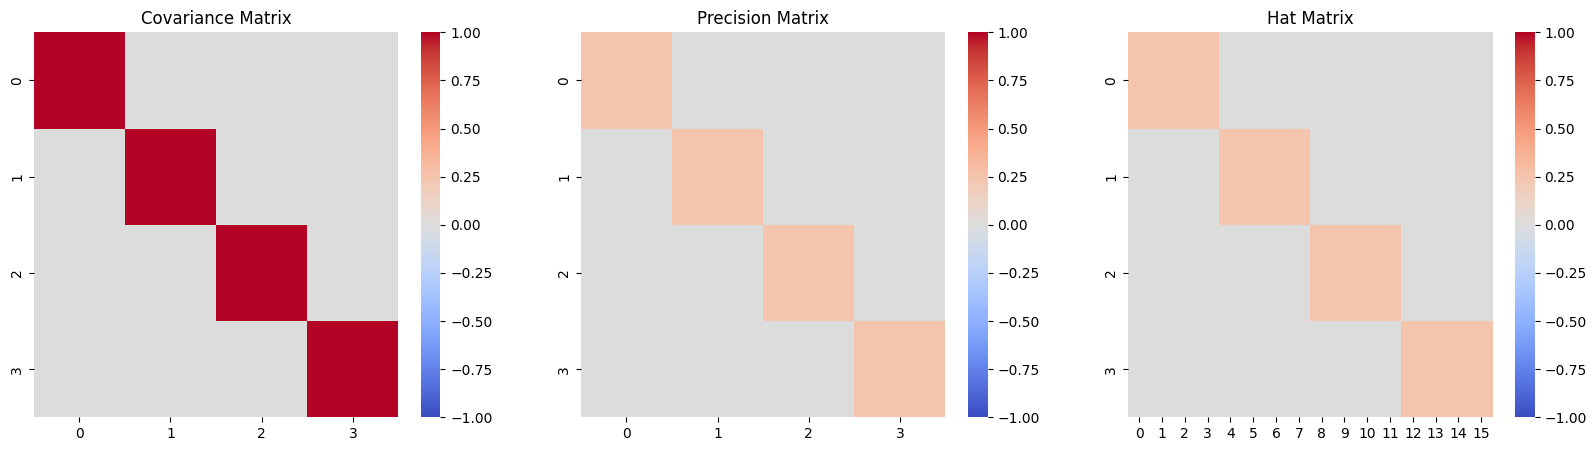

In [ ]:
variable_analysis(design)

In [ ]:
true_outcomes = data['Return']

linear = LinearRegression(fit_intercept=False) # input, output, intercept
linear.fit(design, true_outcomes)
linear_outcomes = linear.predict(design)
linear_weights = linear.coef_

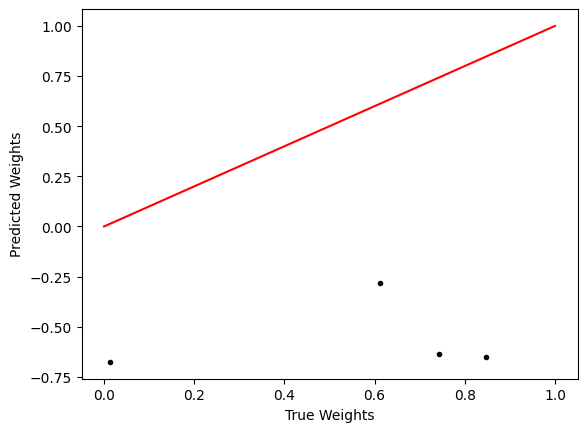

In [ ]:
model_weights_accuracy(weights, linear_weights)

In [ ]:
pred_outcomes = numpy.dot(design, linear_weights)
pred_outcomes

array([-0.65193829, -0.65193829, -0.65193829, -0.65193829, -0.63666687,
       -0.63666687, -0.63666687, -0.63666687, -0.28438031, -0.28438031,
       -0.28438031, -0.28438031, -0.67555836, -0.67555836, -0.67555836,
       -0.67555836])

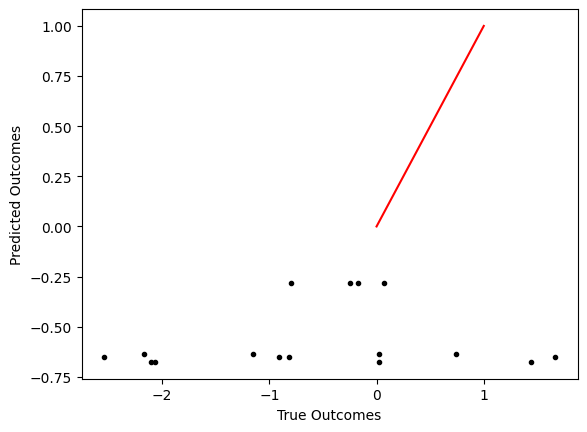

In [ ]:
model_outcomes_accuracy(true_outcomes, linear_outcomes)

In [ ]:
evaluation_metrics(weights, linear_weights, true_outcomes, linear_outcomes)

Mean Squared Error: 1.4574547022377393
Mean Weight Error: 1.1156094448200509
Model Variance: 0.11175509644633916
Standard Deviation: 0.3342979157074408




---

2 variables with noise

---



In [ ]:
data, weights = company_sector_affects(df, NOISE_LEVEL=2, SINGLE_VAR_NOISE=1)
data

,Company Name,Sector,Year,Return
0,FakeCo0-Sector0,Sector0,2018,2.443587
1,FakeCo0-Sector0,Sector0,2019,2.956587
2,FakeCo0-Sector0,Sector0,2020,3.374246
3,FakeCo0-Sector0,Sector0,2021,-3.010022
4,FakeCo1-Sector0,Sector0,2018,-0.654133
5,FakeCo1-Sector0,Sector0,2019,0.593870
6,FakeCo1-Sector0,Sector0,2020,-1.064799
7,FakeCo1-Sector0,Sector0,2021,1.599316
8,FakeCo0-Sector1,Sector1,2018,1.802599
9,FakeCo0-Sector1,Sector1,2019,0.409511


In [ ]:
design = design_matrix_company_sector(data)
design

array([[1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.]])

In [ ]:
matrix_rank = numpy.linalg.matrix_rank(design)
print('Matrix Shape:', design.shape, '\n\n' + 'Matrix Rank:', matrix_rank)

Matrix Shape: (16, 6) 

Matrix Rank: 4


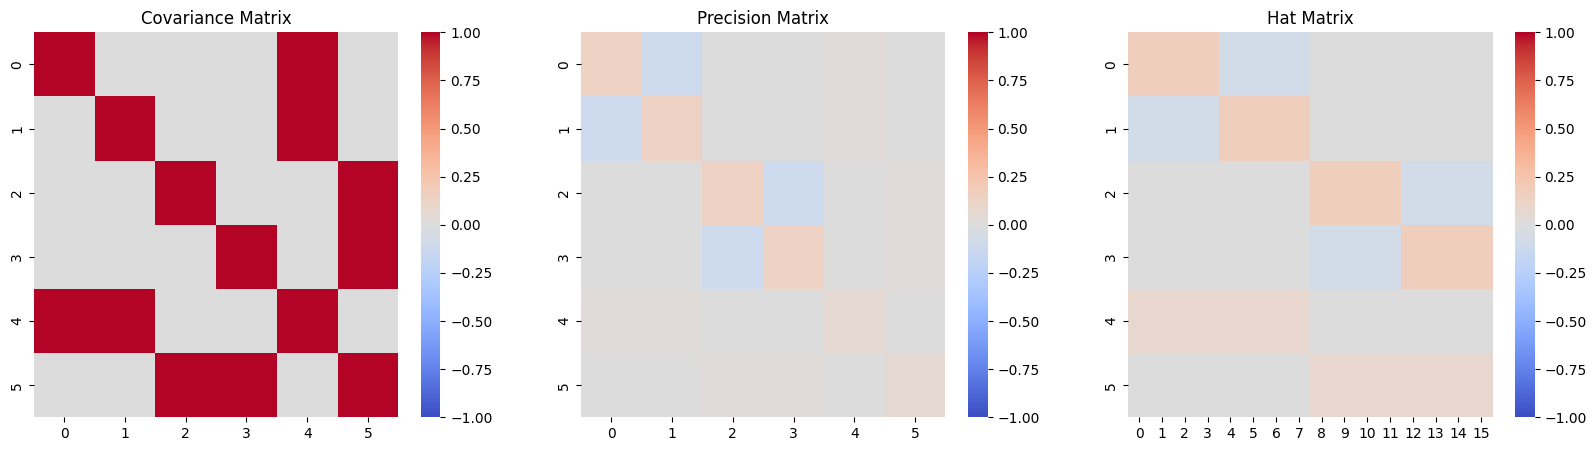

In [ ]:
variable_analysis(design)

In [ ]:
true_outcomes = data['Return']

linear = LinearRegression(fit_intercept=False) # input, output, intercept
linear.fit(design, true_outcomes)
linear_outcomes = linear.predict(design)
linear_weights = linear.coef_

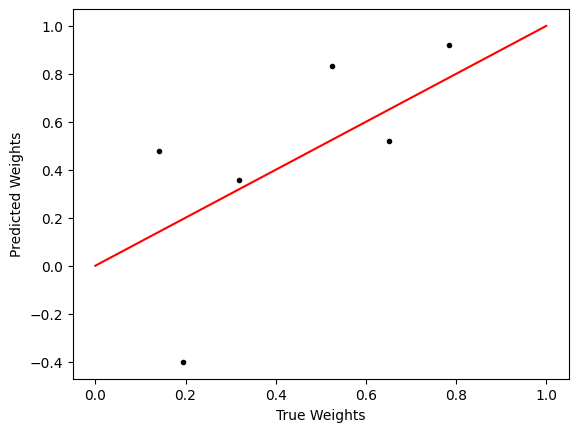

In [ ]:
model_weights_accuracy(weights, linear_weights)
#make way to easily compare with no noise

In [ ]:
pred_outcomes = numpy.dot(design, linear_weights)
pred_outcomes

array([1.44109964, 1.44109964, 1.44109964, 1.44109964, 0.11856368,
       0.11856368, 0.11856368, 0.11856368, 1.31205843, 1.31205843,
       1.31205843, 1.31205843, 1.19209785, 1.19209785, 1.19209785,
       1.19209785])

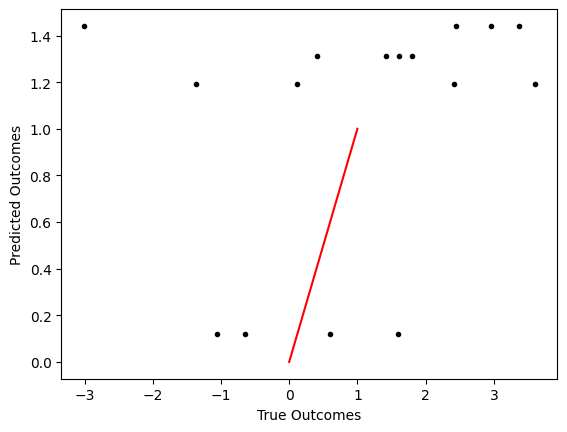

In [ ]:
model_outcomes_accuracy(true_outcomes, linear_outcomes)
#make way to easily compare with no noise

In [ ]:
evaluation_metrics(weights, linear_weights, true_outcomes, linear_outcomes)

Mean Squared Error: 2.963501707269761
Mean Weight Error: -0.01530082978672583
Model Variance: 0.09985234275358983
Standard Deviation: 0.31599421316471893
